In [22]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairsRender, CocoPairsNetwork
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import asyncio
import datetime
import random


import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import plot_pose, get_humans_as_lines, plot_human_lines, is_same_image
import tensorflow as tf
import math
import copy
from tqdm import tqdm
import datetime
sys.path.insert(0, os.path.abspath('..'))


from tf_pose.tensblur.smoother import Smoother


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# params 432, 368
w, h = 432, 368
image_path_source = './data/images/lea_source.jpg'
image_path_target = './data/images/lea_target_near.jpg'
model = 'cmu'
log_dir = 'logs/'
resize_out_ratio = 2.0
image_source = common.read_imgfile(image_path_source, w, h)
image_target = common.read_imgfile(image_path_target, w, h)

summary_writer = tf.summary.FileWriter(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [3]:
e_source = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_target = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
upsample_size = [int(e_target.target_size[1] / 8 * resize_out_ratio), int(e_target.target_size[0] / 8 * resize_out_ratio)]

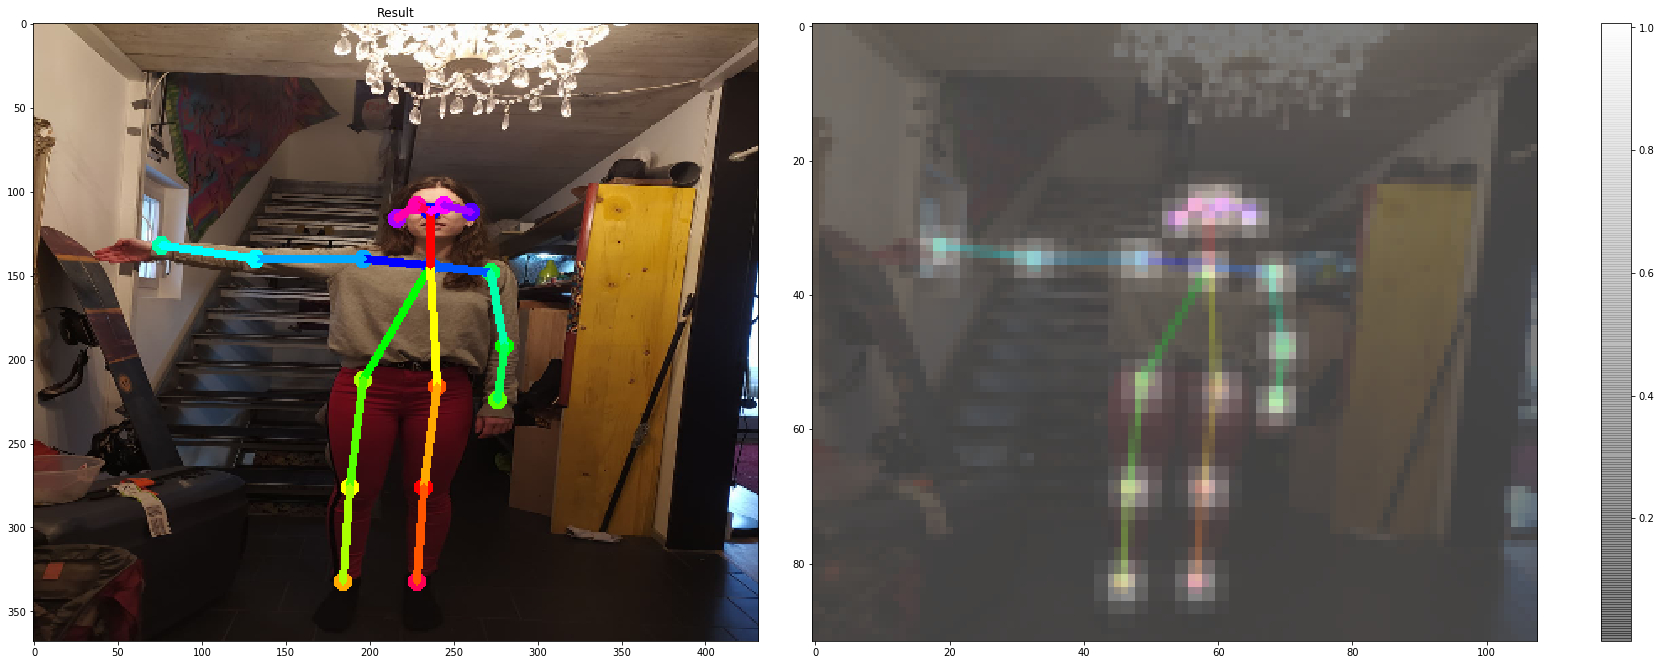

In [4]:
human_source = e_source.inference(image_source, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_source, human_source, e_source.heatMat)

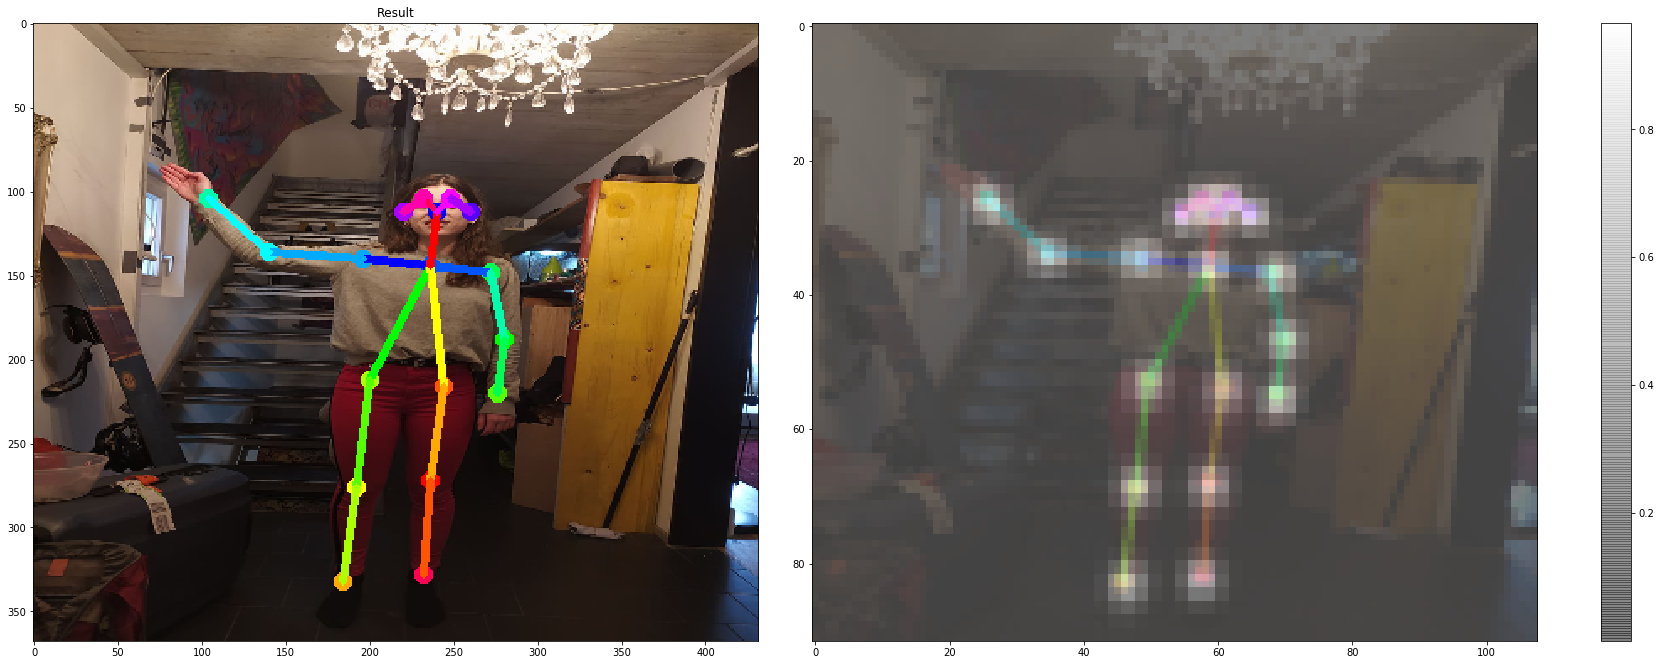

In [5]:
human_target = e_target.inference(image_target, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, e_target.heatMat)

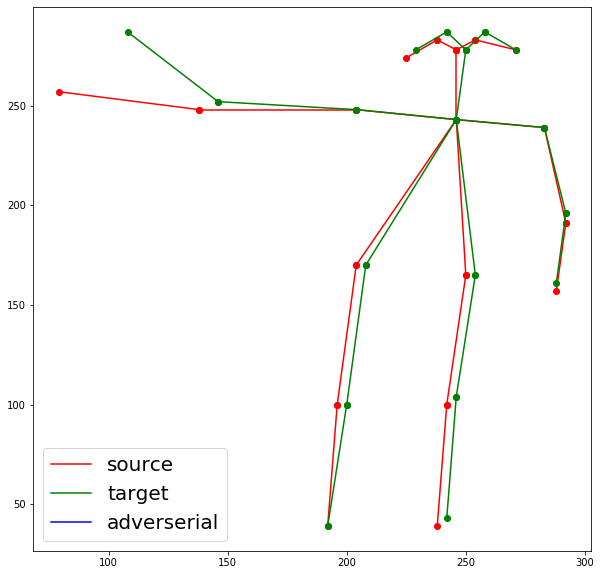

In [6]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [9]:
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = e_target.persistent_sess.run(
            [e_target.tensor_output, e_target.tensor_heatMat_up, e_target.tensor_pafMat_up, e_target.tensor_peaks],
            feed_dict={
                e_target.tensor_image: [image_target],
                e_target.upsample_size: upsample_size
            }
        )

source_np, source_np_heat, source_np_paf, source_np_peaks = e_source.persistent_sess.run(
            [e_source.tensor_output, e_source.tensor_heatMat_up, e_source.tensor_pafMat_up, e_source.tensor_peaks],
            feed_dict={
                e_source.tensor_image: [image_source],
                e_source.upsample_size: upsample_size
            }
        )


In [8]:
ONLY_HEAT = True
USE_PEAK_AS_HEAT = False
# change only the heatmap for the wrist and the required limb vector field
# wrist
temp_target = copy.deepcopy(source_np_heat)
if USE_PEAK_AS_HEAT:
    temp_target[:, :, :, CocoPart.RWrist.value] = target_np_heat[:, :, :, CocoPart.RWrist.value]
else:
    temp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]

target_np_heat = temp_target


# lower arm 
temp_target = copy.deepcopy(source_np_paf)
if ONLY_HEAT:
    LOWER_ARM_RIGTH = 3
    id = CocoPairsNetwork[LOWER_ARM_RIGTH][0]
    temp_target[:, :, :, id] = target_np_paf[:, :, :, id]
    temp_target[:, :, :, id + 1] = target_np_paf[:, :, :, id + 1]

target_np_paf = temp_target

# set the correct peaks
temp_target = copy.deepcopy(source_np_peaks)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np_peaks[:, :, :, CocoPart.RWrist.value]
target_np_peaks = temp_target

# change the output as well
temp_target = copy.deepcopy(source_np)
temp_target[:, :, :, CocoPart.RWrist.value] = target_np[:, :, :, CocoPart.RWrist.value]
if ONLY_HEAT:
    temp_target[:, :, :, id + 19] = target_np[:, :, :, id + 19]
    temp_target[:, :, :, id + 19 + 1] = target_np[:, :, :, id + 19 + 1]
target_np = temp_target

(1, 46, 54, 57)
(1, 92, 108, 19)
(1, 92, 108, 38)
(1, 92, 108, 19)


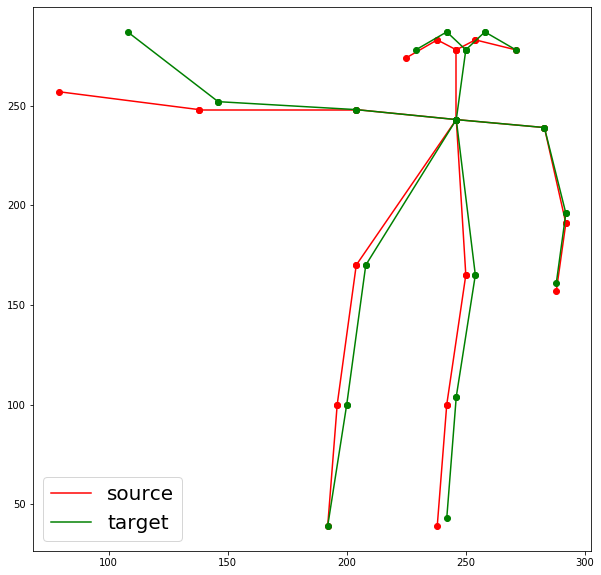

In [10]:
print(target_np.shape)
print(target_np_heat.shape)
print(target_np_paf.shape)
print(target_np_peaks.shape)

# for i in range(52):
#     print(np.sum(np.abs(target_np[:, :, :, i] - source_np[:, :, :, i])))


human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [25]:
# the target state
# the loss defined in the paper
def multi_stage_loss():
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))

    eps = tf.constant(0.05, name='Epsilon')


    losses_per_stage = []
    # compute loss per stage
    for stage in range(2, 7): 
        paf_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L1/BiasAdd').outputs[0]
        heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage{stage}_L2/BiasAdd').outputs[0]

        # check if concat works 
        # compute the loss for every channel
        loss_paf = tf.nn.l2_loss(tf.concat(paf_op, axis=-1) - tf.concat(target_paf, axis=-1), name='AX_loss_l1_stage%d_' % (stage))
        loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage%d_' % (stage))
        losses_per_stage.append(tf.reduce_sum([loss_paf, loss_heat]))

    # combined loss form every stage
    total_loss = tf.reduce_sum(losses_per_stage)
    summary = tf.summary.scalar('grad_norm', total_loss)


    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, summary

# only use the final stage and only care about the hgeatmaps
def final_stage_heat_loss(target_heat):
    heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage6_L2/BiasAdd').outputs[0]
    
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage7_')

    # combined loss form every stage
    total_loss = tf.reduce_sum(loss_heat)
    summary = tf.summary.scalar('loss_heat', total_loss)

    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, summary

# only use a single heatmap for the loss
def final_stage_single_heat_loss(target_heat, index):
    heat_op = e_source.graph.get_operation_by_name(f'TfPoseEstimator/Mconv7_stage6_L2/BiasAdd').outputs[0][:, :, :, index]
    
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_loss_l2_stage7_')

    # combined loss form every stage
    total_loss = tf.reduce_sum(loss_heat)
    summary = tf.summary.scalar('loss_heat', total_loss)


    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, summary
# x_adv = e_source.tensor_image - eps * tf.sign(grad)
# x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
# x_adv = tf.stop_gradient(x_adv)
def final_stage_single_heat_upsampled_loss(target_heat, index):
    # No gradient defined for operation 'upsample_heatmat' (op type: ResizeArea)
    heat_op = e_source.graph.get_operation_by_name(f'upsample_heatmat').outputs[0][:, :, :, index]
    
    loss_heat = tf.nn.l2_loss(tf.concat(heat_op, axis=-1) - tf.concat(target_heat, axis=-1), name='AX_upsample_heatmat')

    # combined loss form every stage
    total_loss = tf.reduce_sum(loss_heat)


    grad = tf.gradients(total_loss, e_source.tensor_image)[0]
    return grad, total_loss

def print_image_Stats(img):
    print(f'Min: {np.min(img)}')
    print(f'Max: {np.max(img)}')
    print(f'Avg: {np.average(img)}')
    
def compare_poses(pose1, pose2):
    total_diff = 0
    cur_max = 0
    most_moved_part = ''
    if(len(pose1.body_parts) != len(pose2.body_parts)):
        print('Poses have different length of body parts')
        return 0, 'NONE'
    for i in pose1.body_parts.keys():
        part1 = pose1.body_parts[i]
        part2 = pose2.body_parts[i]
        part1_pos =  np.array([part1.x, part1.y])
        part2_pos =  np.array([part2.x, part2.y])
        cur_diff = np.linalg.norm(part1_pos - part2_pos)
        if cur_diff > cur_max:
            most_moved_part = part1.get_part_name()
            cur_max = cur_diff
        total_diff += cur_diff
    return total_diff, most_moved_part

def compute_distance(pose1, pose2, index):
    if index not in pose1.body_parts or index not in pose2.body_parts:
        print(f'{index} not in both poses found')
        return 0
    part1 = pose1.body_parts[index]
    part2 = pose2.body_parts[index]
    part1_pos =  np.array([part1.x, part1.y])
    part2_pos =  np.array([part2.x, part2.y])
    return np.linalg.norm(part1_pos - part2_pos)

In [28]:
EPS = 5000
STEPS = 100
ONLY_SINGLE_HEAT_MAP_AS_LOSS = False


if not "adv_image" in vars():
    adv_image = copy.deepcopy(image_source)
target_heat, grad_func, loss_func = [None, None, None]

human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


if ONLY_SINGLE_HEAT_MAP_AS_LOSS:
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None))
    grad_func, loss_func = final_stage_single_heat_loss(target_heat, CocoPart.RWrist.value)
else:
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    grad_func, loss_func = final_stage_heat_loss(target_heat)

print(f'Distance from source to target right wrist {compute_distance(human_source[0], human_target[0], CocoPart.RWrist.value)}')
for i in tqdm(range(STEPS)):    
    # compute gradient
    gradient, gn_summ = e_source.persistent_sess.run(
                [grad_func, loss_func],
                feed_dict={
                    target_heat: target_np[:, :, :, CocoPart.RWrist.value] if ONLY_SINGLE_HEAT_MAP_AS_LOSS else target_np[:, :, :, :19],
                    # target_paf: target_np[:, :, :, 19:],
                    e_source.tensor_image: [adv_image],
                    e_source.upsample_size: upsample_size
                }
            )
    summary_writer.add_summary(gn_summ, i)
#     summary_writer
#     # compute loss before applying the gradient
#     loss_before = e_source.persistent_sess.run(
#                 loss_func,
#                 feed_dict={
#                     target_heat: target_np[:, :, :, CocoPart.RWrist.value] if ONLY_SINGLE_HEAT_MAP_AS_LOSS else target_np[:, :, :, :19],
#                     # target_paf: target_np[:, :, :, 19:],
#                     e_source.tensor_image: [adv_image],
#                     e_source.upsample_size: upsample_size
#                 }
#             )
#     
    
    ### ================= UPDATE STEP ================= ###
    #adv_image = adv_image - EPS * np.sign(gradient[0])
    adv_image = adv_image - EPS * gradient[0]
    adv_image = np.clip(adv_image, 0, 255)
    print(f'{i}: Loss: {loss_before}')
    if i % 50 == 0:
        human_adv = e_source.inference(np.clip(adv_image, 0, 255), resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
        print(f'Distance from adv to target right wrist {compute_distance(human_adv[0], human_target[0], CocoPart.RWrist.value)}')





human_adv = e_source.inference(adv_image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)




    
print_image_Stats(image_source)
print_image_Stats(adv_image)
total_diff, most_moved_part = compare_poses(human_source[0], human_adv[0])
print(f'The total diff is {total_diff} and the part moved the most is the {most_moved_part}')

  0%|          | 0/100 [00:00<?, ?it/s]

Distance from source to target right wrist 0.09995091381383042
0: Loss: 0.021666595712304115


  1%|          | 1/100 [00:06<09:59,  6.06s/it]

Distance from adv to target right wrist 0.0


  2%|▏         | 2/100 [00:09<08:41,  5.32s/it]

1: Loss: 0.021666595712304115


  3%|▎         | 3/100 [00:13<08:07,  5.02s/it]

2: Loss: 0.021666595712304115


  4%|▍         | 4/100 [00:18<07:41,  4.80s/it]

3: Loss: 0.021666595712304115


  5%|▌         | 5/100 [00:22<07:26,  4.70s/it]

4: Loss: 0.021666595712304115


  6%|▌         | 6/100 [00:27<07:17,  4.66s/it]

5: Loss: 0.021666595712304115


  7%|▋         | 7/100 [00:31<07:08,  4.61s/it]

6: Loss: 0.021666595712304115


  8%|▊         | 8/100 [00:36<06:54,  4.51s/it]

7: Loss: 0.021666595712304115


  9%|▉         | 9/100 [00:40<06:43,  4.43s/it]

8: Loss: 0.021666595712304115


 10%|█         | 10/100 [00:44<06:43,  4.48s/it]

9: Loss: 0.021666595712304115


 11%|█         | 11/100 [00:49<06:37,  4.46s/it]

10: Loss: 0.021666595712304115


 12%|█▏        | 12/100 [00:53<06:32,  4.45s/it]

11: Loss: 0.021666595712304115


 13%|█▎        | 13/100 [00:58<06:21,  4.39s/it]

12: Loss: 0.021666595712304115


 14%|█▍        | 14/100 [01:02<06:26,  4.49s/it]

13: Loss: 0.021666595712304115


 15%|█▌        | 15/100 [01:07<06:20,  4.48s/it]

14: Loss: 0.021666595712304115


 16%|█▌        | 16/100 [01:11<06:14,  4.46s/it]

15: Loss: 0.021666595712304115


 17%|█▋        | 17/100 [01:16<06:21,  4.60s/it]

16: Loss: 0.021666595712304115


 18%|█▊        | 18/100 [01:21<06:30,  4.76s/it]

17: Loss: 0.021666595712304115


 19%|█▉        | 19/100 [01:26<06:16,  4.65s/it]

18: Loss: 0.021666595712304115


 20%|██        | 20/100 [01:30<06:05,  4.57s/it]

19: Loss: 0.021666595712304115


 21%|██        | 21/100 [01:34<05:59,  4.55s/it]

20: Loss: 0.021666595712304115


 22%|██▏       | 22/100 [01:39<05:53,  4.53s/it]

21: Loss: 0.021666595712304115


 23%|██▎       | 23/100 [01:44<05:53,  4.59s/it]

22: Loss: 0.021666595712304115


 24%|██▍       | 24/100 [01:48<05:45,  4.54s/it]

23: Loss: 0.021666595712304115


 25%|██▌       | 25/100 [01:53<05:44,  4.59s/it]

24: Loss: 0.021666595712304115


 26%|██▌       | 26/100 [01:58<06:02,  4.90s/it]

25: Loss: 0.021666595712304115


 27%|██▋       | 27/100 [02:03<05:59,  4.92s/it]

26: Loss: 0.021666595712304115


 28%|██▊       | 28/100 [02:08<05:57,  4.96s/it]

27: Loss: 0.021666595712304115


 29%|██▉       | 29/100 [02:13<05:47,  4.89s/it]

28: Loss: 0.021666595712304115


 30%|███       | 30/100 [02:18<05:38,  4.84s/it]

29: Loss: 0.021666595712304115


 31%|███       | 31/100 [02:23<05:33,  4.84s/it]

30: Loss: 0.021666595712304115


 32%|███▏      | 32/100 [02:28<05:39,  4.99s/it]

31: Loss: 0.021666595712304115


 33%|███▎      | 33/100 [02:33<05:42,  5.12s/it]

32: Loss: 0.021666595712304115


 34%|███▍      | 34/100 [02:39<05:48,  5.28s/it]

33: Loss: 0.021666595712304115


 35%|███▌      | 35/100 [02:44<05:39,  5.22s/it]

34: Loss: 0.021666595712304115


 36%|███▌      | 36/100 [02:49<05:23,  5.05s/it]

35: Loss: 0.021666595712304115


 37%|███▋      | 37/100 [02:53<05:10,  4.92s/it]

36: Loss: 0.021666595712304115


 38%|███▊      | 38/100 [02:58<05:01,  4.87s/it]

37: Loss: 0.021666595712304115


 39%|███▉      | 39/100 [03:03<04:54,  4.83s/it]

38: Loss: 0.021666595712304115


 40%|████      | 40/100 [03:08<04:49,  4.83s/it]

39: Loss: 0.021666595712304115


 41%|████      | 41/100 [03:13<04:44,  4.82s/it]

40: Loss: 0.021666595712304115


 42%|████▏     | 42/100 [03:18<04:53,  5.07s/it]

41: Loss: 0.021666595712304115


 43%|████▎     | 43/100 [03:23<04:47,  5.04s/it]

42: Loss: 0.021666595712304115


 44%|████▍     | 44/100 [03:28<04:39,  4.99s/it]

43: Loss: 0.021666595712304115


 45%|████▌     | 45/100 [03:33<04:31,  4.94s/it]

44: Loss: 0.021666595712304115


 46%|████▌     | 46/100 [03:38<04:31,  5.03s/it]

45: Loss: 0.021666595712304115


 47%|████▋     | 47/100 [03:44<04:39,  5.28s/it]

46: Loss: 0.021666595712304115


 48%|████▊     | 48/100 [03:49<04:34,  5.27s/it]

47: Loss: 0.021666595712304115


 49%|████▉     | 49/100 [03:55<04:31,  5.32s/it]

48: Loss: 0.021666595712304115


 50%|█████     | 50/100 [04:00<04:19,  5.20s/it]

49: Loss: 0.021666595712304115
50: Loss: 0.021666595712304115


 51%|█████     | 51/100 [04:06<04:37,  5.67s/it]

Distance from adv to target right wrist 0.0


 52%|█████▏    | 52/100 [04:11<04:16,  5.35s/it]

51: Loss: 0.021666595712304115


 53%|█████▎    | 53/100 [04:16<04:00,  5.12s/it]

52: Loss: 0.021666595712304115


 54%|█████▍    | 54/100 [04:20<03:50,  5.00s/it]

53: Loss: 0.021666595712304115


 55%|█████▌    | 55/100 [04:25<03:41,  4.91s/it]

54: Loss: 0.021666595712304115


 56%|█████▌    | 56/100 [04:30<03:34,  4.86s/it]

55: Loss: 0.021666595712304115


 57%|█████▋    | 57/100 [04:35<03:32,  4.94s/it]

56: Loss: 0.021666595712304115


 58%|█████▊    | 58/100 [04:40<03:32,  5.05s/it]

57: Loss: 0.021666595712304115


 59%|█████▉    | 59/100 [04:45<03:26,  5.03s/it]

58: Loss: 0.021666595712304115


 60%|██████    | 60/100 [04:50<03:20,  5.01s/it]

59: Loss: 0.021666595712304115


 61%|██████    | 61/100 [04:55<03:15,  5.02s/it]

60: Loss: 0.021666595712304115


 62%|██████▏   | 62/100 [05:00<03:07,  4.94s/it]

61: Loss: 0.021666595712304115


 63%|██████▎   | 63/100 [05:04<02:57,  4.80s/it]

62: Loss: 0.021666595712304115


 64%|██████▍   | 64/100 [05:09<02:49,  4.71s/it]

63: Loss: 0.021666595712304115


 65%|██████▌   | 65/100 [05:13<02:42,  4.65s/it]

64: Loss: 0.021666595712304115


 66%|██████▌   | 66/100 [05:18<02:37,  4.62s/it]

65: Loss: 0.021666595712304115


 67%|██████▋   | 67/100 [05:23<02:32,  4.61s/it]

66: Loss: 0.021666595712304115


 68%|██████▊   | 68/100 [05:27<02:27,  4.61s/it]

67: Loss: 0.021666595712304115


 69%|██████▉   | 69/100 [05:32<02:23,  4.63s/it]

68: Loss: 0.021666595712304115


 70%|███████   | 70/100 [05:36<02:18,  4.63s/it]

69: Loss: 0.021666595712304115


 71%|███████   | 71/100 [05:41<02:13,  4.61s/it]

70: Loss: 0.021666595712304115


 72%|███████▏  | 72/100 [05:46<02:12,  4.75s/it]

71: Loss: 0.021666595712304115


 73%|███████▎  | 73/100 [05:51<02:07,  4.72s/it]

72: Loss: 0.021666595712304115


 74%|███████▍  | 74/100 [05:56<02:03,  4.73s/it]

73: Loss: 0.021666595712304115


 75%|███████▌  | 75/100 [06:00<01:57,  4.70s/it]

74: Loss: 0.021666595712304115


 76%|███████▌  | 76/100 [06:05<01:51,  4.65s/it]

75: Loss: 0.021666595712304115


 77%|███████▋  | 77/100 [06:09<01:47,  4.66s/it]

76: Loss: 0.021666595712304115


 78%|███████▊  | 78/100 [06:14<01:42,  4.68s/it]

77: Loss: 0.021666595712304115


 79%|███████▉  | 79/100 [06:19<01:38,  4.69s/it]

78: Loss: 0.021666595712304115


 80%|████████  | 80/100 [06:24<01:34,  4.75s/it]

79: Loss: 0.021666595712304115


 81%|████████  | 81/100 [06:29<01:33,  4.91s/it]

80: Loss: 0.021666595712304115


 82%|████████▏ | 82/100 [06:33<01:26,  4.79s/it]

81: Loss: 0.021666595712304115


 83%|████████▎ | 83/100 [06:38<01:20,  4.72s/it]

82: Loss: 0.021666595712304115


 84%|████████▍ | 84/100 [06:43<01:14,  4.69s/it]

83: Loss: 0.021666595712304115


 85%|████████▌ | 85/100 [06:47<01:09,  4.65s/it]

84: Loss: 0.021666595712304115


 86%|████████▌ | 86/100 [06:52<01:04,  4.61s/it]

85: Loss: 0.021666595712304115


 87%|████████▋ | 87/100 [06:56<00:59,  4.58s/it]

86: Loss: 0.021666595712304115


 88%|████████▊ | 88/100 [07:01<00:56,  4.72s/it]

87: Loss: 0.021666595712304115


 89%|████████▉ | 89/100 [07:06<00:51,  4.67s/it]

88: Loss: 0.021666595712304115


 90%|█████████ | 90/100 [07:10<00:46,  4.63s/it]

89: Loss: 0.021666595712304115


 91%|█████████ | 91/100 [07:15<00:41,  4.59s/it]

90: Loss: 0.021666595712304115


 92%|█████████▏| 92/100 [07:19<00:36,  4.59s/it]

91: Loss: 0.021666595712304115


 93%|█████████▎| 93/100 [07:24<00:32,  4.59s/it]

92: Loss: 0.021666595712304115


 94%|█████████▍| 94/100 [07:29<00:27,  4.60s/it]

93: Loss: 0.021666595712304115


 95%|█████████▌| 95/100 [07:33<00:22,  4.60s/it]

94: Loss: 0.021666595712304115


 96%|█████████▌| 96/100 [07:38<00:18,  4.60s/it]

95: Loss: 0.021666595712304115


 97%|█████████▋| 97/100 [07:42<00:13,  4.61s/it]

96: Loss: 0.021666595712304115


 98%|█████████▊| 98/100 [07:47<00:09,  4.61s/it]

97: Loss: 0.021666595712304115


 99%|█████████▉| 99/100 [07:52<00:04,  4.71s/it]

98: Loss: 0.021666595712304115


100%|██████████| 100/100 [07:57<00:00,  4.77s/it]

99: Loss: 0.021666595712304115


Min: 0
Max: 255
Avg: 64.82726323470209
Min: 0.0
Max: 255.0
Avg: 65.04278564453125
The total diff is 0.24018047871710813 and the part moved the most is the CocoPart.RWrist


2020-01-27 20:15:59,129 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 368, 432, 3)
Min: -2.1010553609812632e-05
Max: 2.5379486032761633e-05
Avg: -3.9038730581530956e-10


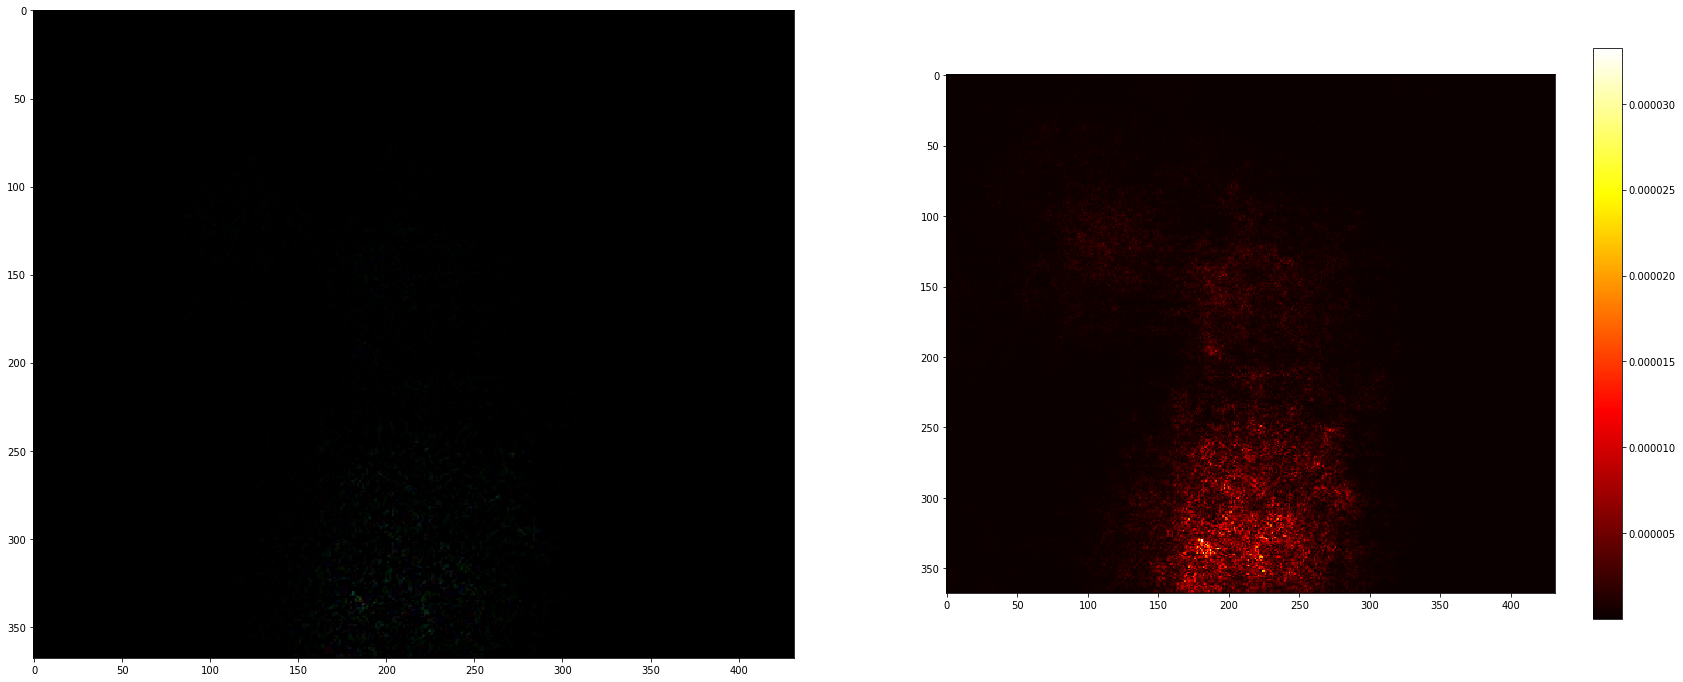

In [29]:
SCALE = 10000
print(gradient.shape)
print_image_Stats(gradient[0])
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(gradient[0] * SCALE)


grad_len = np.zeros((gradient[0].shape[:2]))
for y in range(gradient[0].shape[0]):
    for x in range(gradient[0].shape[1]):
        cur_vec = gradient[0, y, x]
        grad_len[y, x] = np.linalg.norm(cur_vec)

ax = fig.add_subplot(1, 2, 2)
heat_image = ax.imshow(grad_len, cmap='hot')
fig.colorbar(heat_image, ax=ax, shrink=0.35)

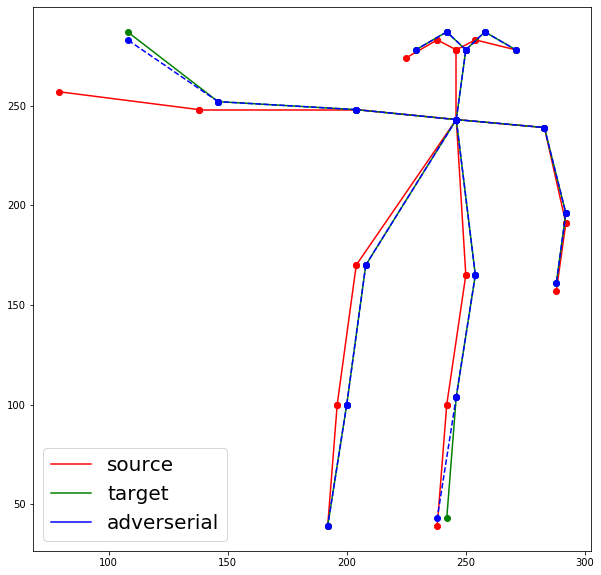

In [31]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)
adv_lines = get_humans_as_lines(human_adv, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')
plot_human_lines(adv_lines, ax, color='b', linestyle='--', label='adv')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

2020-01-27 20:16:08,014 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


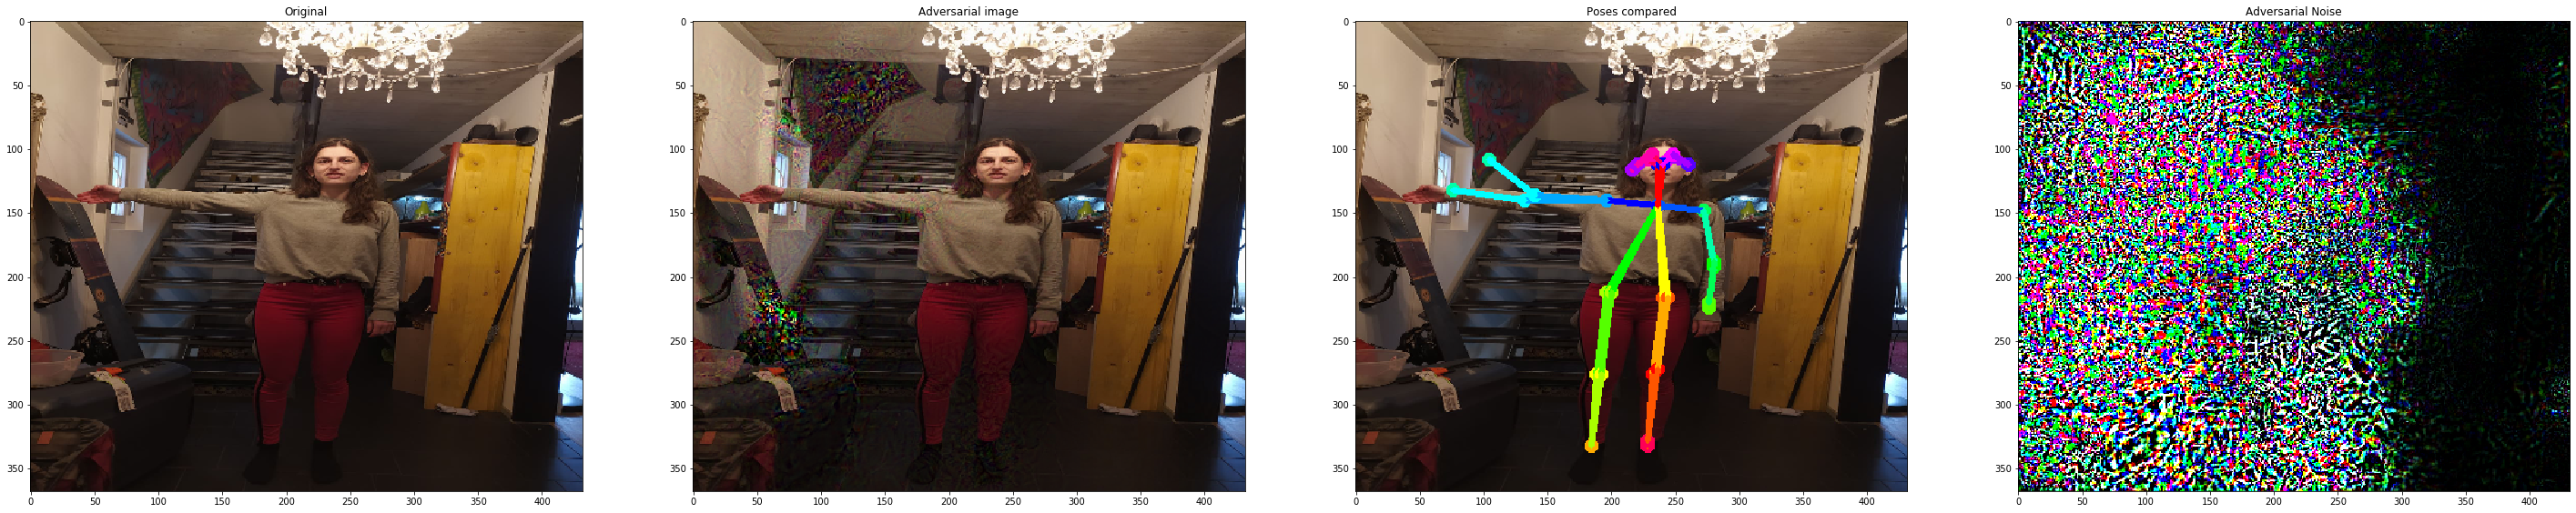

In [32]:
fig = plt.figure(figsize=(50, 25))

ax = fig.add_subplot(1, 4, 1)
ax.imshow(cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB))
ax.set_title('Original')

adv_image_cliped = np.clip(adv_image, 0, 255) / 255
ax = fig.add_subplot(1, 4, 2)
ax.imshow(cv2.cvtColor(adv_image_cliped, cv2.COLOR_BGR2RGB))
ax.set_title('Adversarial image')


image_source_result = TfPoseEstimator.draw_humans(image_source, human_source, imgcopy=True)
image_source_result = TfPoseEstimator.draw_humans(image_source_result, human_adv, imgcopy=True)

ax = fig.add_subplot(1, 4, 3)
ax.set_title('Poses compared')
ax.imshow(cv2.cvtColor(image_source_result, cv2.COLOR_BGR2RGB))

ax = fig.add_subplot(1, 4, 4)
ax.set_title('Adversarial Noise')
noise = image_source - adv_image
ax.imshow(noise)

38.09294


Text(0.5, 1.0, 'Difference')

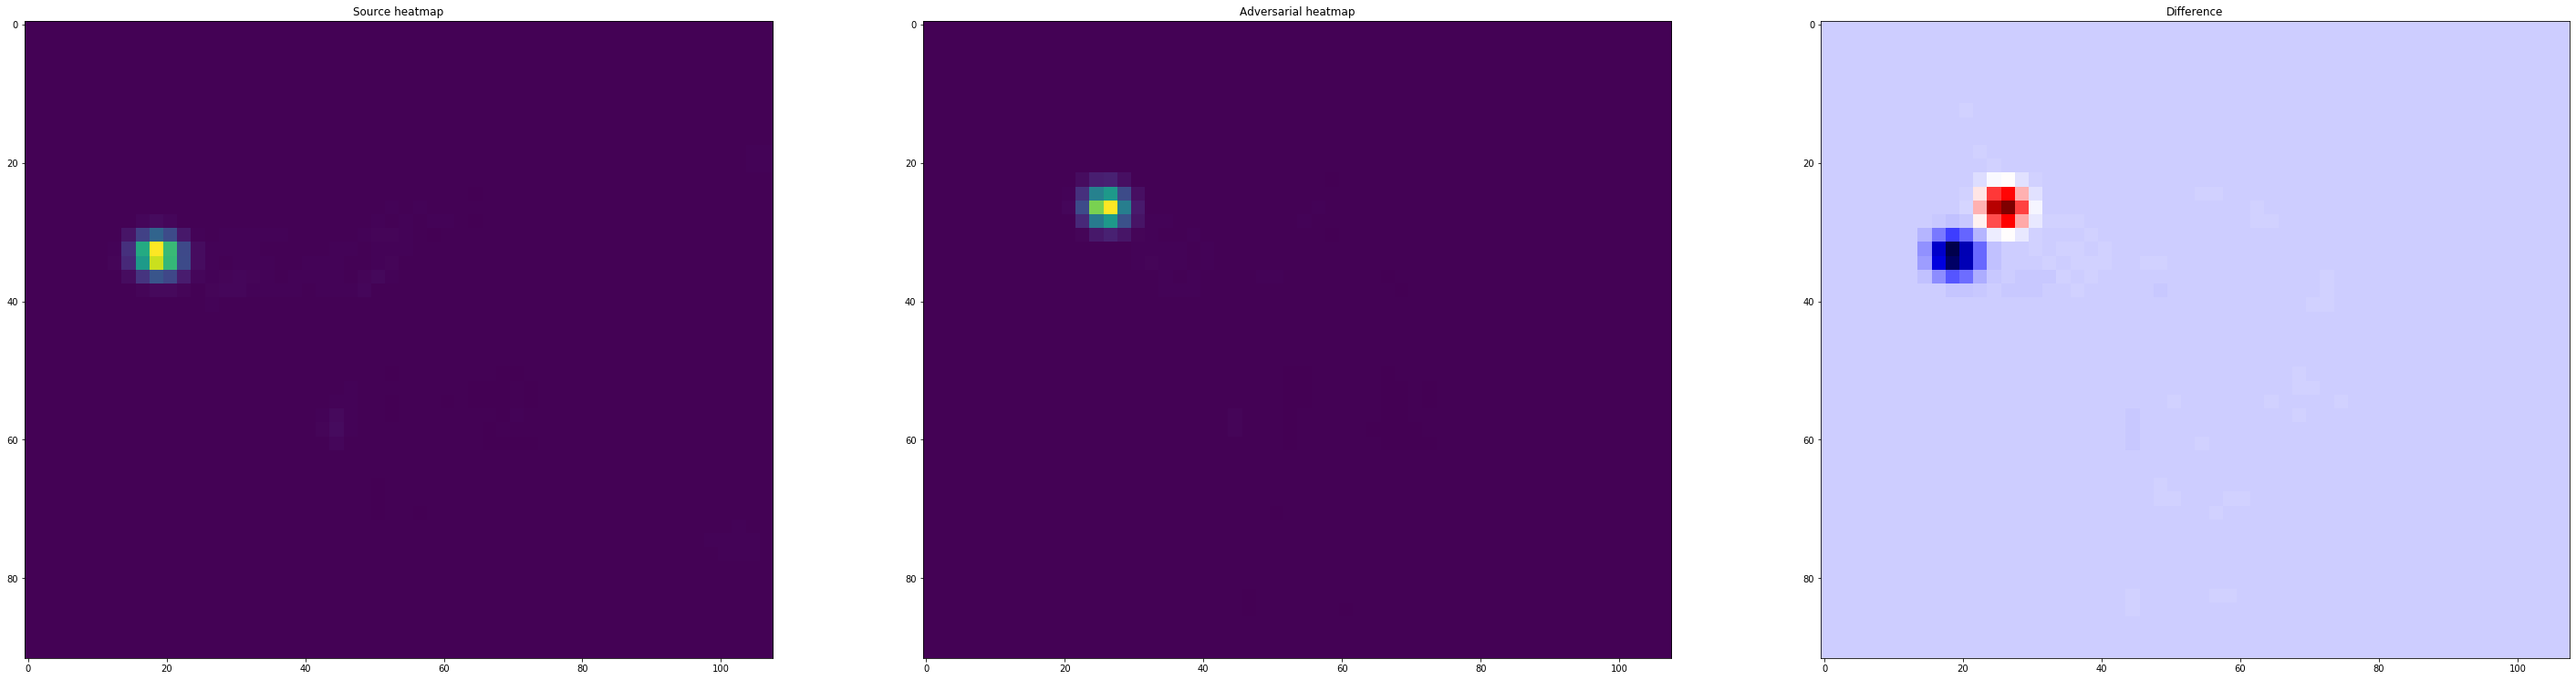

In [18]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_heat[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source heatmap')

ax = fig.add_subplot(1, 3, 2)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value])
ax.set_title('Adversarial heatmap')

print(is_same_image(source_np_heat[0,: ,:, CocoPart.RWrist.value], e_source.heatMat[:,:, CocoPart.RWrist.value]))
ax = fig.add_subplot(1, 3, 3)
ax.imshow(e_source.heatMat[:,:, CocoPart.RWrist.value] - source_np_heat[0,: ,:, CocoPart.RWrist.value], cmap='seismic')
ax.set_title('Difference')

In [20]:
def compute_peaks(tensor_heat_placeholder):
    tensor_heatMat_up = tf.image.resize_area(tensor_heat_placeholder, upsample_size,
                                                          align_corners=False, name='upsample_heatmat')

    smoother = Smoother({'data': tensor_heatMat_up}, 25, 3.0)
    gaussian_heatMat = smoother.get_output()

    max_pooled_in_tensor = tf.nn.pool(gaussian_heatMat, window_shape=(3, 3), pooling_type='MAX', padding='SAME')
    tensor_mask = tf.equal(gaussian_heatMat, max_pooled_in_tensor)
    tensor_peaks = tf.where(tensor_mask, gaussian_heatMat, tf.zeros_like(gaussian_heatMat))
    e_source.persistent_sess.run(tf.variables_initializer(
            [v for v in tf.global_variables() if
             v.name.split(':')[0] in [x.decode('utf-8') for x in
                                      e_source.persistent_sess.run(tf.report_uninitialized_variables())]
             ])
        )
    return tensor_peaks




tensor_heat_placeholder = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
tensor_peaks = compute_peaks(tensor_heat_placeholder)

# run for adversarial imape 
[adv_np_peaks] = e_source.persistent_sess.run(
    [tensor_peaks],
            feed_dict={
                tensor_heat_placeholder: np.expand_dims(e_source.heatMat, axis=0)
            }
        )

Over all difference 0.1772901862859726
Localation of the peak in source (33, 19)
Localation of the peak in adv (26, 26)
Localation of the peak in target (26, 26)


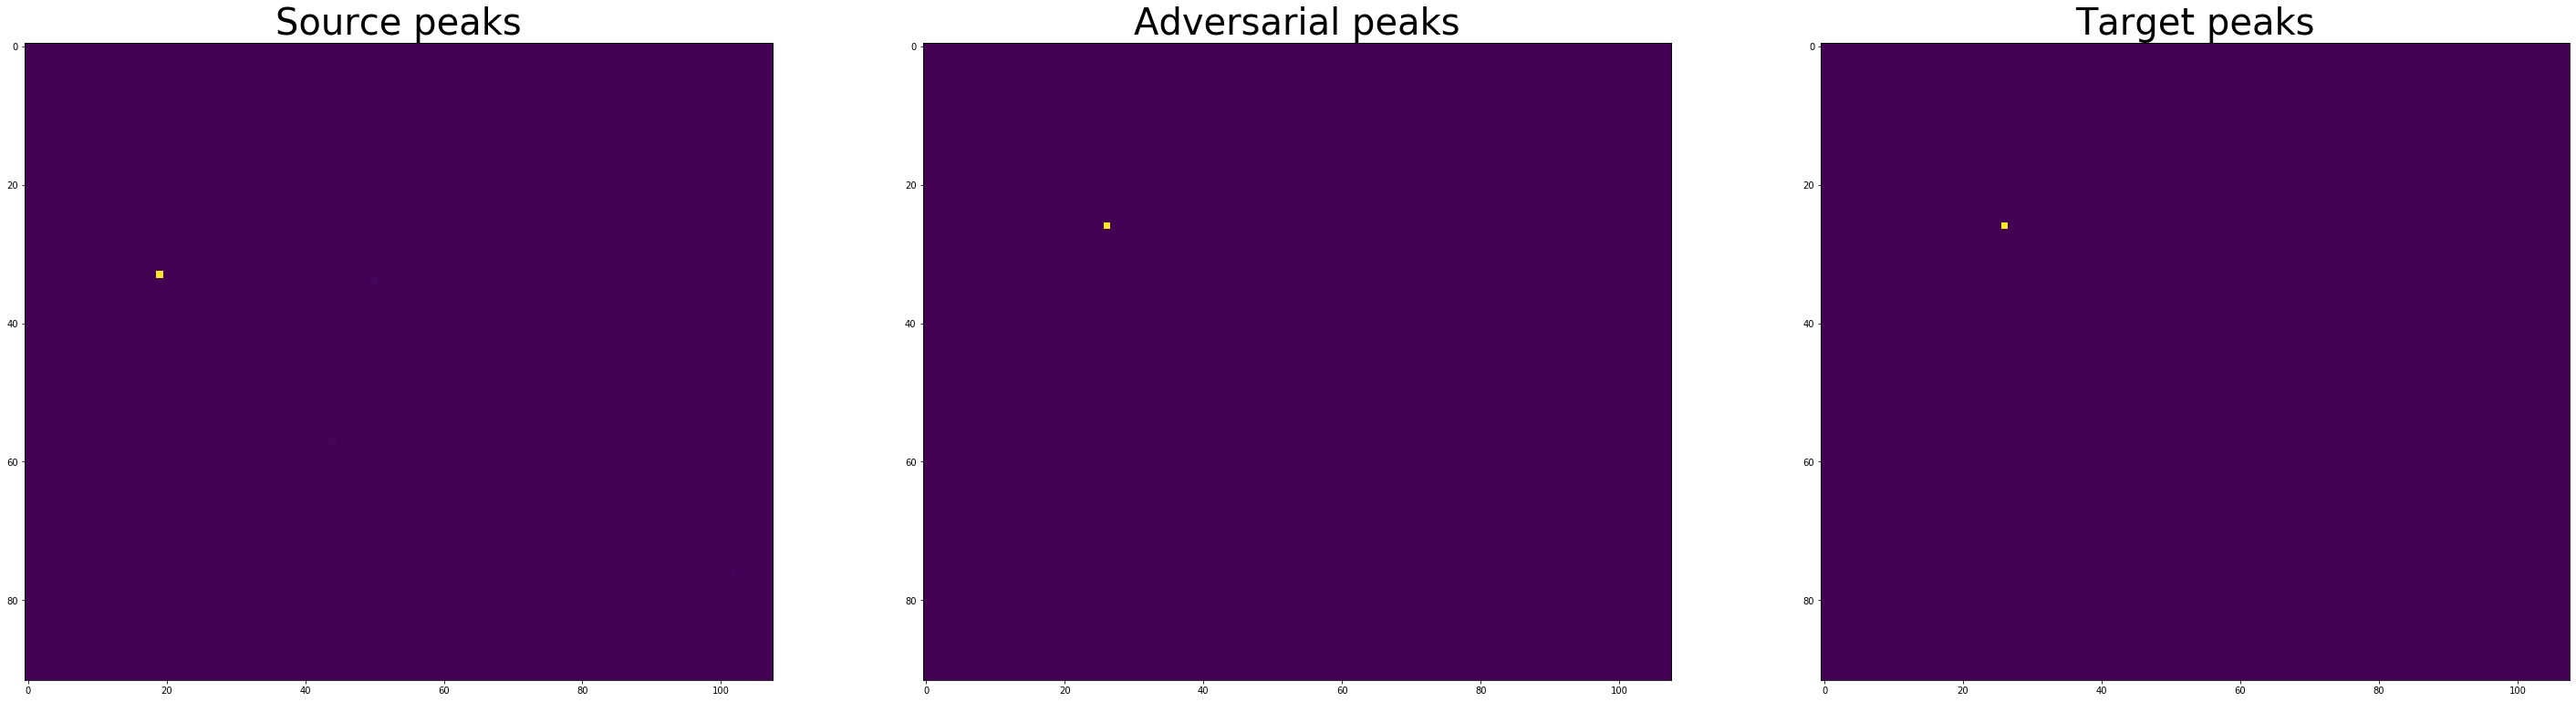

In [21]:
fig = plt.figure(figsize=(50, 25))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(source_np_peaks[0,: ,:, CocoPart.RWrist.value])
ax.set_title('Source peaks', fontdict = {'fontsize' : 40})

ax = fig.add_subplot(1, 3, 2)
ax.imshow(adv_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Adversarial peaks', fontdict = {'fontsize' : 40})

print(f'Over all difference {is_same_image(adv_np_peaks[0, : ,:, CocoPart.RWrist.value], source_np_peaks[0, :, :, CocoPart.RWrist.value])}')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(target_np_peaks[0, :,:, CocoPart.RWrist.value])
ax.set_title('Target peaks', fontdict = {'fontsize' : 40})

print(f'Localation of the peak in source {np.unravel_index(source_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), source_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')
print(f'Localation of the peak in adv {np.unravel_index(adv_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), adv_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')

print(f'Localation of the peak in target {np.unravel_index(target_np_peaks[0,: ,:, CocoPart.RWrist.value].argmax(), target_np_peaks[0,: ,:, CocoPart.RWrist.value].shape)}')

In [35]:
from deepexplain.tf.v1_x import DeepExplain

with DeepExplain(session=e_source.persistent_sess, graph=e_source.graph) as de:
        
        input_tensor = e_source.tensor_image
        output_tensor = e_source.tensor_heatMat[:, :, :, CocoPart.RWrist.value]
        xs = tf.expand_dims(image_source, 0).eval(session=e_source.persistent_sess)
        xs = xs.astype('float64')
       
        Y_shape=[None] + [1, 46, 54] # size of heatmaps
        
        #ys = np.expand_dims(np.expand_dims(current_stats["mask"], axis=0), axis=0)
        
        baseline = np.zeros(list(xs.shape)[1:]) # baseline to compare against
        saliency = de.explain('saliency', T=output_tensor, X=input_tensor, xs=xs, Y_shape=Y_shape)
        gradInput = de.explain('grad*input', T=output_tensor, X=input_tensor, xs=xs,  Y_shape=Y_shape)

/home/ax/master/2019_02/masterThesis/DeepExplain/deepexplain/tf/v1_x/main.py:94: UserWarning: DeepExplain detected you are trying to use an attribution method that requires gradient override but the original gradient was used instead. You might have forgot to (re)create your graph within the DeepExlain context. Results are not reliable!
  warnings.warn('DeepExplain detected you are trying to use an attribution method that requires '


2020-01-24 16:51:53,348 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2020-01-24 16:51:53,367 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


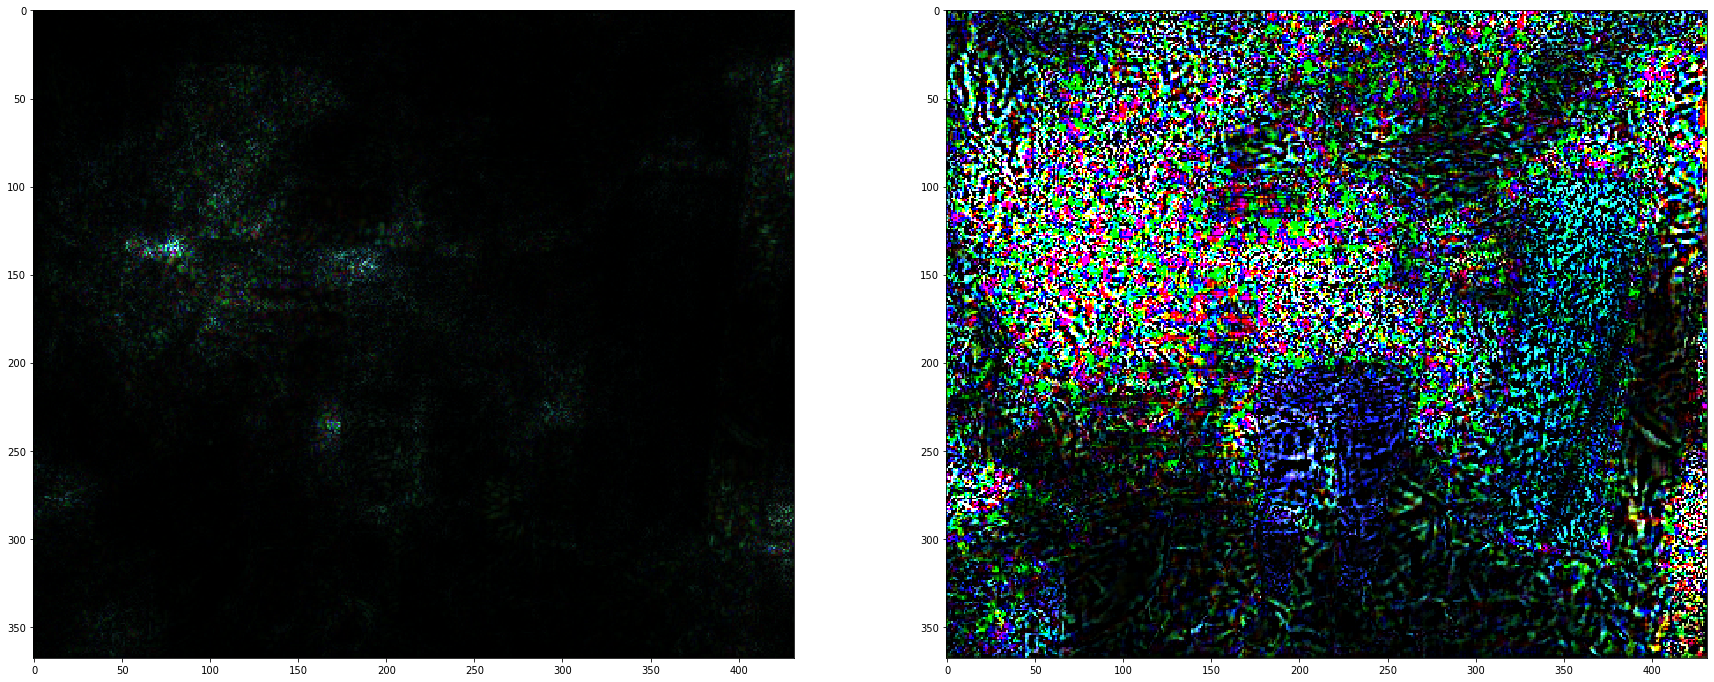

In [36]:
SCALE = 1000
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(saliency[0] * SCALE)

ax = fig.add_subplot(1, 2, 2)
heat_image = ax.imshow(gradInput[0] * SCALE, cmap='hot')